# Task 3 - Prediction-based anomaly detection

### Library imports

In [1]:
# Data management
import numpy as np
import pandas as pd
from math import ceil

# Plotting
from matplotlib.pyplot import plot, figure, title, xlabel, ylabel, legend, show, savefig, boxplot
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from seaborn import heatmap

# Tests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.stats import zscore, norm
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape, mean_absolute_error as mae

# ARIMA construction
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Neural networks
import keras

## Task 3.1 Anomaly detection for uni-variate series with ARIMA

### Helper functions

In [25]:
# Loads data set from CSV file, given filename as input
# Returns both numpy array and Pandas DataFrame
# The latter is simpler to implement as plots
def load_csv_data(file_name : str):
    data_np = np.loadtxt(file_name, delimiter = ",", dtype = float)
    data_pd = pd.read_csv(file_name, names = ["Year", "Value"])

    return data_np, data_pd

# Line plot, histogram, density plot, heat map, box plot, lag-1 plot, lag-2 plot, ACF/PACF plots
# Pandas DataFrame structure allows simple implementation of plots
def plot_all(data_set : pd.core.frame.DataFrame, lags : int = 40, xlabel : str = "Values", title : str = ""):
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(25, 25))
    fig.subplots_adjust()
    fig.suptitle(title, fontsize=24)
    
    # Line plot
    data_set.plot(y = "Value", ax = axes[0,0], kind = 'line', title = 'Line plot')

    # Histogram plot
    data_set.plot(x = "Year", y = "Value",ax = axes[0,1], kind = 'hist', title = 'Histogram', ylabel = 'Frequency')

    # Density plot
    data_set.plot(x = "Year", y = "Value",ax = axes[1,0], kind = 'density', title = 'Density plot', ylabel = 'Density')
    
    # Heatmap
    heatmap_data_set = data_set.set_index("Year")
    heatmap(heatmap_data_set, ax = axes[1,1], cmap = "viridis")

    # Box plot
    data_set.plot(x = "Year", y = "Value",ax = axes[2,0], kind = 'box', title = 'Box plot')
    
    # Lag plots
    data_set_series = pd.Series(data_set.loc[:, 'Value'])
    pd.plotting.lag_plot(data_set_series, ax = axes[3,0], lag = 1)
    pd.plotting.lag_plot(data_set_series, ax = axes[3,1], lag = 2)

    # ACF and PACF plots
    plot_acf(data_set_series, ax = axes[4,0])
    plot_pacf(data_set_series, lags = lags, ax=axes[4,1], method='ywm');

# Test for stationarity
def adfuller_test(data_set: pd.core.frame.DataFrame):
    result = adfuller(data_set.loc[:, "Value"], autolag='AIC')
    adfstat = result[0]
    pvalue = result[1]
    print("-"*30)
    print(f'ADF Statistic: {adfstat}')
    print(f'p-value: {pvalue}')

    critvals_lt_adfstat = 0
    print('Critial Values:')
    for key, value in result[4].items():
        print(f'{key}, {value}')
        if (value < adfstat):
            critvals_lt_adfstat += 1
    print("-"*30)
    print(f"Critical values less than adf statistic: {critvals_lt_adfstat}")
    print(f"p-value is below the 5% significance level: {pvalue < 0.05}")
    print(f"Stationary? {critvals_lt_adfstat == 0 and pvalue < 0.05}")
    print("-"*30)
    print("")

# Difference given data set to ensure stationarity
def difference_data_set(data_set : pd.core.frame.DataFrame):
    temp_arr = []

    # Difference the data set
    for index, val in enumerate(data_set.loc[:, "Value"]):
        if (index != 0):
            temp_arr.append(val - prev_val)
        prev_val = val
    
    # Structure data set into DataFrame type
    temp_dict = {"Year" : data_set.loc[1:, "Year"], "Value" : temp_arr}
    diff_data_set = pd.DataFrame(data = temp_dict)

    return diff_data_set

# Prints mean and standard deviation of data_set
def feat_extract(data_set : pd.core.frame.DataFrame):
    mean = data_set["Value"].mean()
    std = data_set["Value"].std()

    print(f"Mean: {mean}\nStandard deviation: {std}")


# Calculates zscore for a series
# If anomaly (zscore > 3) is detected, index and value is output
def detect_anomaly(data_set, conf_interval = 0.997):
    scores = zscore(data_set)

    zscore_threshold = norm.ppf(conf_interval)

    for index, val in enumerate(scores):
        if(val > zscore_threshold or val < -zscore_threshold):
            print(f"ZScore: Anomaly detected at index {index + 1} with score {val}")
    
    


### Exploratory Data Analysis (EDA)

Load the data and test for stationarity using ADF method


In [3]:
# Load data
data_np, data_pd = load_csv_data("Data Sets\global_land_temperature_anomalies.csv")

# Check for stationarity
adfuller_test(data_pd)

------------------------------
ADF Statistic: 0.9382926419378832
p-value: 0.993570249862259
Critial Values:
1%, -3.479007355368944
5%, -2.8828782366015093
10%, -2.5781488587564603
------------------------------
Critical values less than adf statistic: 3
p-value is below the 5% significance level: False
Stationary? False
------------------------------



As data is *not* stationary, we conduct a first-order differencing as an attempt to solve this. We analyze our results by running another ADF test

In [4]:
# Difference data
diff_data_set = data_pd.diff().dropna()

# Check for stationarity
adfuller_test(diff_data_set)

------------------------------
ADF Statistic: -12.165503286659842
p-value: 1.4604869372130722e-22
Critial Values:
1%, -3.479007355368944
5%, -2.8828782366015093
10%, -2.5781488587564603
------------------------------
Critical values less than adf statistic: 0
p-value is below the 5% significance level: True
Stationary? True
------------------------------



The differenced data set is now stationary. We plot the requested figures

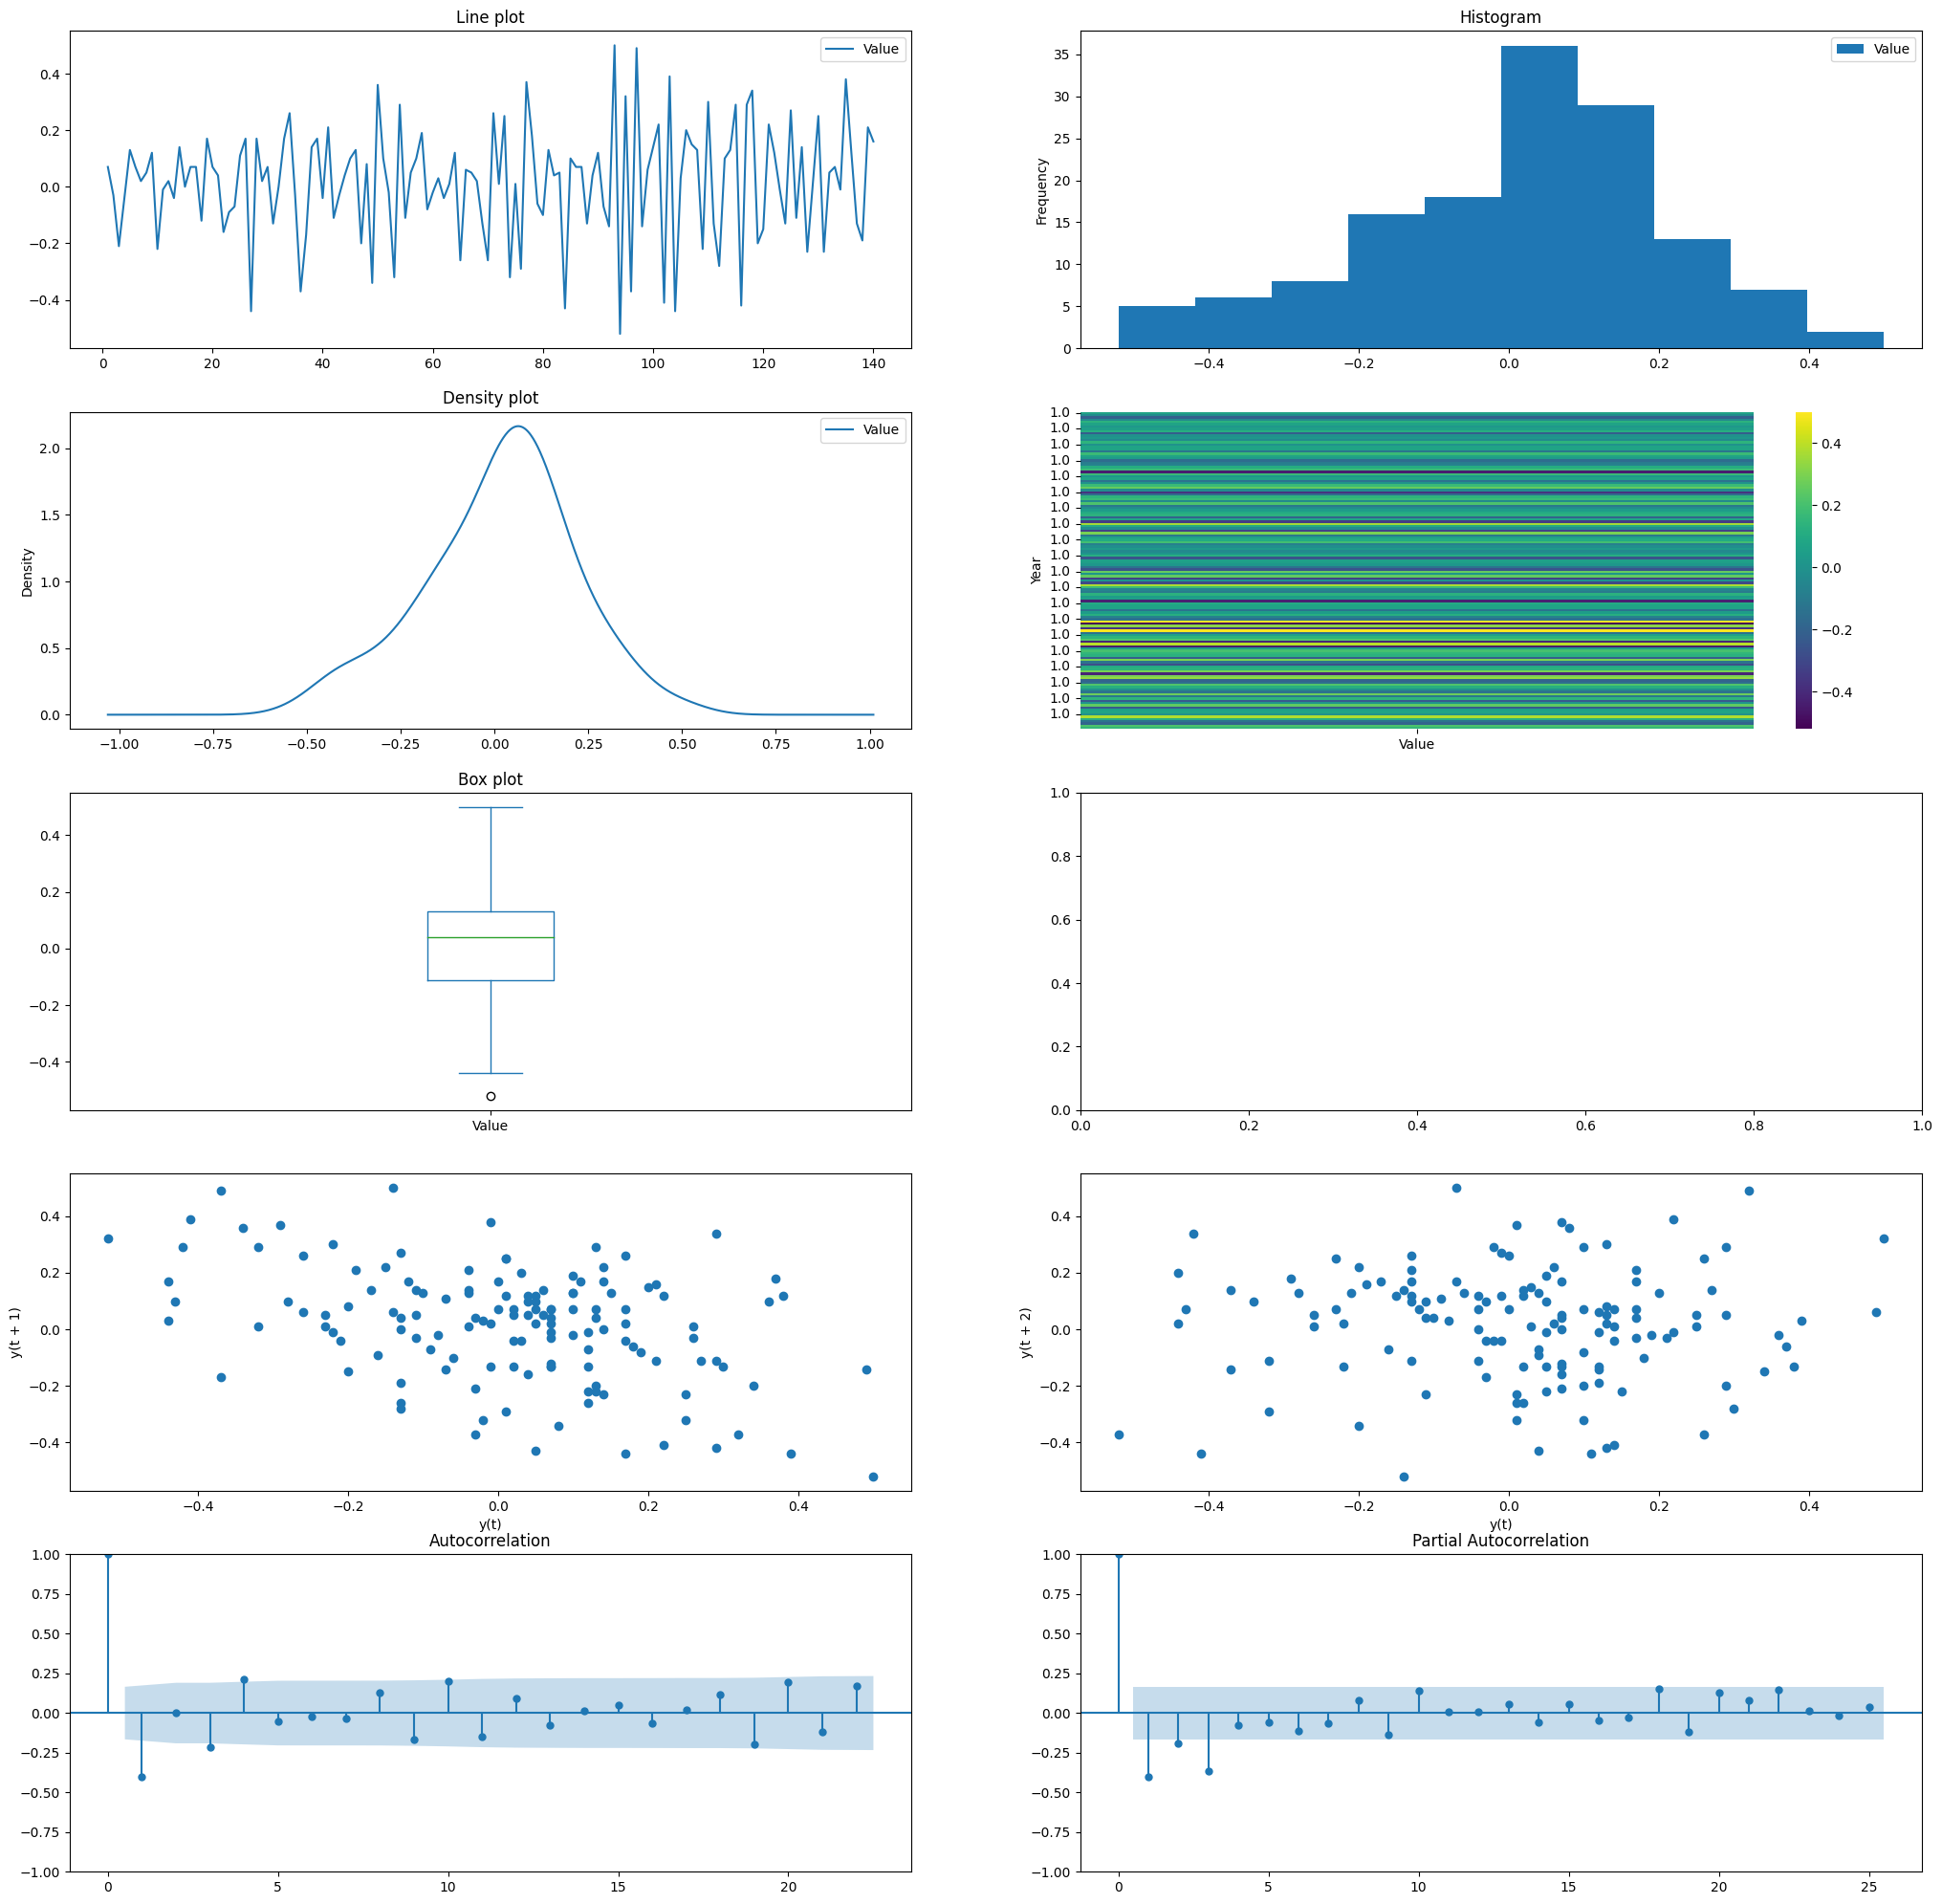

In [26]:
# Plot data
plot_all(diff_data_set, lags = 25)

### Feature Extraction

The temporal correlation can be found in the last two plots above. We calculate and print the mean and standard deviation for the differenced data set below

In [6]:
# Extract and present features
feat_extract(diff_data_set)

Mean: 0.01492857142857143
Standard deviation: 0.1995840870683185


### Model Construction and Selection

We follow Box-Jenkins methodology to construct an ARIMA-model.

Step 1 requires us to check for stationarity (and, if it does not exist, ensure stationarity through differencing) followed by considering seasonality (in which case, a SARIMA-model must be considered). Our data set has already achieved stationarity, and no signs of seasonality can be seen. Furthermore, as we have applied differencing to ensure stationarity, the order of *d* can be found to be zero, thereby turning our ARIMA into an ARMA-model.

Step 2 asks us to identify the orders of the ARMA-model. One method to accomplish this is from the ACF and PACF plots, which reveal the MA(p) and AR(q) values. By finding the first occurrence of a lag which falls within the confidence interval, we can determine the order of *p* from the PACF, and the order of *q* from the ACF. Visual identification reveals these to be *4* and *2*, respectively.

Step 3 has us combine the MA- and AR-processes into an ARMA-process, and finding the fitting *p* and *q* values for the combined process. This can be done using the AIC criterion, which the $\texttt{auto\_arima()}$ function handles for us. This step handles the construction of the model, as done below.

The optimal model seems to be using (p, d, q) = (2, 1, 4) as attributes. We construct it below as well.

In [7]:
# Auto_arima runs a grid-patterned test to find the optimal p,d,q attributes using AIC-criterion by default
diff_series = diff_data_set["Value"]
diff_series.index = diff_data_set["Year"]
diff_series = pd.Series(diff_series).dropna()
auto_arima(diff_series, start_p = 0, max_p = 5, d = 1, start_q = 0, max_q = 5, seasonal = False, trace = True)

model = ARIMA(endog = diff_series, order=(2, 1, 4)).fit()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=93.740, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.236, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=91.741, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.489, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-27.815, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-42.862, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-47.324, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-82.874, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-81.521, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-85.108, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-86.478, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-87.512, Time=0.08 sec

c:\Users\Zani\Documents\IL2233\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Zani\Documents\IL2233\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Zani\Documents\IL2233\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Zani\Documents\IL2233\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Prediction

We use our model to conduct in-sample prediction and generate the prediction error series. Finally, we check if the error series is random or not using Ljungbox test.

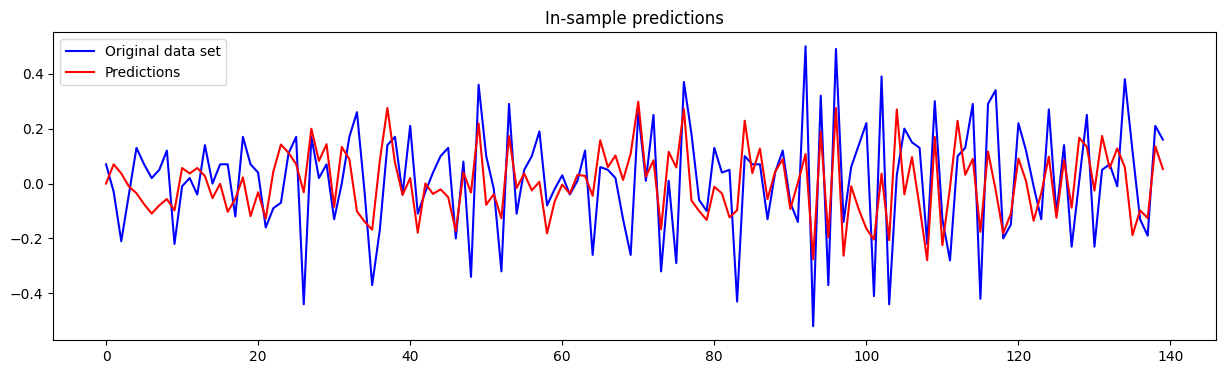

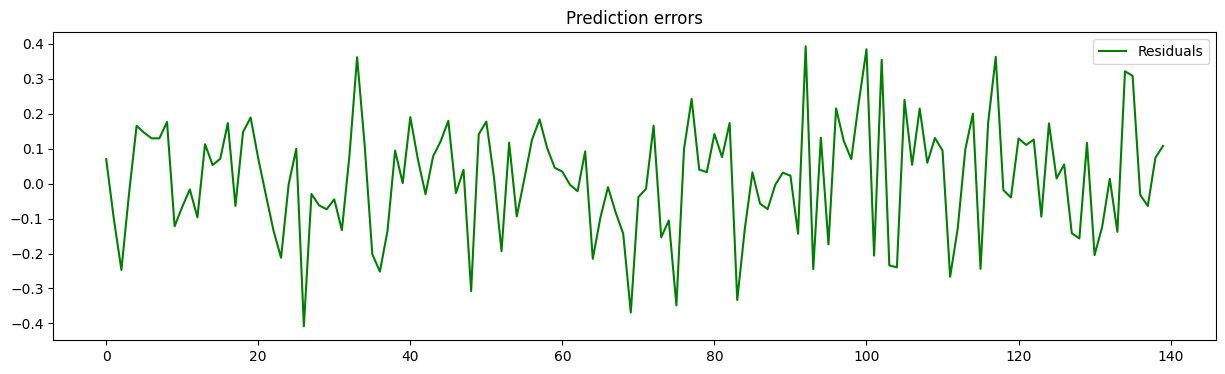

In [8]:
# Generate in-sample predictions
predictions = model.get_prediction()
pred_values = predictions.predicted_mean

# Visualize data set and predictions
figure(figsize=(15, 4))
title('In-sample predictions')
plot(diff_series.values, color='blue', label='Original data set')
plot(pred_values.values, color='red', label='Predictions')
legend()
show()

# Generate remainder/prediction error series
residuals = diff_series.values - pred_values.values
figure(figsize=(15, 4))
title('Prediction errors')
plot(residuals, color='green', label='Residuals')
legend()
show()

In [9]:
# Determine if residuals are random
sm.stats.acorr_ljungbox(residuals)
# Results indicate that residuals are random

,lb_stat,lb_pvalue
1,0.101102,0.750512
2,0.286283,0.866631
3,0.454701,0.928725
4,0.467981,0.976542
5,0.469638,0.993193
6,0.815430,0.991654
7,1.846654,0.967838
8,3.148180,0.924717
9,4.085303,0.905709
10,4.914337,0.896826


### Anomaly detection

We proceed to identify and mark anomalies using the z-score and boxplot criterion.

Using zscore-method, we find six anomalies. Using boxplot-method, we find five anomalies and visually inspect them.

The anomalies seem to correspond across both methods, save for zscore with one additional anomaly it has identified.

Further below, we visualize the anomalies in the original data series

ZScore: Anomaly detected at index 27 with score -2.6102767108905853
ZScore: Anomaly detected at index 34 with score 2.142090074842967
ZScore: Anomaly detected at index 70 with score -2.3662147917156093
ZScore: Anomaly detected at index 76 with score -2.242318027573415
ZScore: Anomaly detected at index 84 with score -2.1461519859332983
ZScore: Anomaly detected at index 93 with score 2.3359251069419864
ZScore: Anomaly detected at index 101 with score 2.283744395149596
ZScore: Anomaly detected at index 103 with score 2.096162951550473
ZScore: Anomaly detected at index 118 with score 2.149442995559736
[]


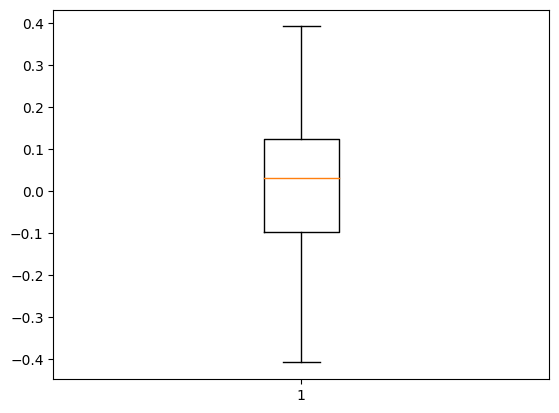

In [31]:
detect_anomaly(residuals, conf_interval = 0.98)
boxplot_vals = boxplot(residuals);

# for i in range(135, 141):
#     print(data_pd["Value"][i])

print(boxplot_vals["fliers"][0].get_ydata())


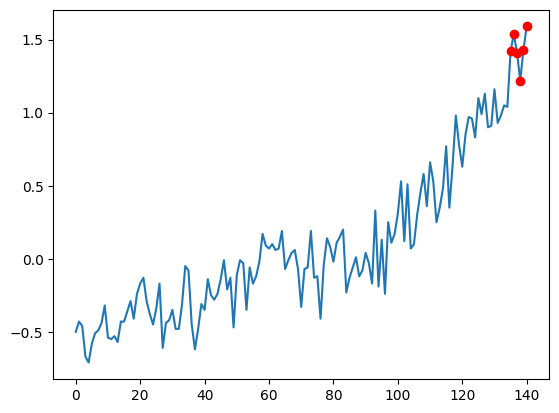

In [11]:
plot(data_pd["Value"])
plot([135, 136, 137, 138, 139, 140], [data_pd["Value"][135], data_pd["Value"][136], data_pd["Value"][137], data_pd["Value"][138], data_pd["Value"][139], data_pd["Value"][140]], 'ro')

### Discussion

1. Since this task uses a different approach (prediction-based anomaly detection) from Task 2 which uses decomposition for anomaly detection, describe what the differences of the two methods are?
The largest benefit this method achieves over decomposition-based anomaly-detection is that it can allow for out-of-sample anomaly detection. Furthermore, decomposition seems to rely mostly on visually identifying anomalies. This can be useful for gaining intuition and insight into the data, as visually perceiving the data is easier for humans than relying on complicated formulas.

2. Do they achieve the same results? Why or Why not?
In the end, yes. This only applies for the same data set, and not for future data points. The method of achieving the results also differ, which may play into strengths and weaknesses of the researcher/engineer.

3. Given the anomaly ratio of 2%, what is the value of z-score?
Approximately 2.05, as the confidence interval becomes 98%.the 

## Task 3.2 Anomaly detection with LSTM in ECG signals

### Helper Functions

In [12]:
# # Loads data set from CSV file, given filename as input
# # Returns both numpy array and Pandas DataFrame
# # The latter is simpler to implement as plots
# # Removes line 0 from 100.csv, if they contain str element (easier data processing)
# def load_csv_data(file_name : str):
#     data_pd = pd.read_csv(file_name)
    
#     return data_pd

# Function to convert data into supervised learning data sets
# Returns input data and labels as two numpy arrays
def transform_data_set(data, input_size, output_size):
    arr_len = len(data) - input_size - output_size + 1
    input_data = np.zeros((arr_len, input_size))
    label = np.zeros((arr_len, output_size))

    for i in range(arr_len):
        for j in range(input_size):
            input_data[i, j] = data[i + j]
        for k in range(output_size):
            if(i < (arr_len)):
                label[i, k] = data[i + input_size + k]

    return input_data, label

# Separate data into training data and testing data
def split_data(data, train_size : float = 0.8):
    train_size = int(len(data) * train_size)
    train, test = data[0:train_size], data[train_size:len(data)]

    test = test.reset_index(drop=True)
    
    return train, test

# Line plot, lag-1 plot, lag-2 plot
# Pandas DataFrame structure allows simple implementation of plots
def plot_all(data_set : pd.core.series.Series, lags : int = 40, xlabel : str = "Values", title : str = "Plots for ECG data"):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(25, 25))
    fig.subplots_adjust()
    fig.suptitle(title, fontsize=24)
    
    # Line plot
    data_set.plot(y = '\'MLII\'', ax = axes[0], kind = 'line', title = 'Line plot', xlabel = "Elapsed time", ylabel = 'Voltage')
    data_set.plot(y = '\'V5\'', ax = axes[0], kind = 'line', title = 'Line plot', xlabel = "Elapsed time", ylabel = 'Voltage')
    
    # Lag plots
    data_set_series_MLII = pd.Series(data_set['\'MLII\''])
    data_set_series_V5 = pd.Series(data_set['\'V5\''])
    pd.plotting.lag_plot(data_set_series_MLII, ax = axes[1], lag = 1)
    pd.plotting.lag_plot(data_set_series_V5, ax = axes[1], lag = 1, c = "Orange")
    axes[1].title.set_text('Lag-1 plot')
    axes[1].legend(['MLII', 'V5'])
    pd.plotting.lag_plot(data_set_series_MLII, ax = axes[2], lag = 2)
    pd.plotting.lag_plot(data_set_series_V5, ax = axes[2], lag = 2, c = "Orange")
    axes[2].title.set_text('Lag-2 plot')
    axes[2].legend(['MLII', 'V5'])

# Calculates zscore for a series
# If anomaly (zscore > 3) is detected, index and value is output
def detect_anomaly(data_set, conf_interval = 0.997):
    scores = zscore(data_set)

    zscore_threshold = norm.ppf(conf_interval)

    for index, val in enumerate(scores):
        if(val > zscore_threshold or val < -zscore_threshold):
            print(f"ZScore: Anomaly detected at index {index + 1} with score {val}")


### Data handling

In [13]:
# Load csv data from file
data_pd = pd.read_csv("Data Sets\hundred.csv", header = 0, index_col = 0)

### Exploratory Data Analysis

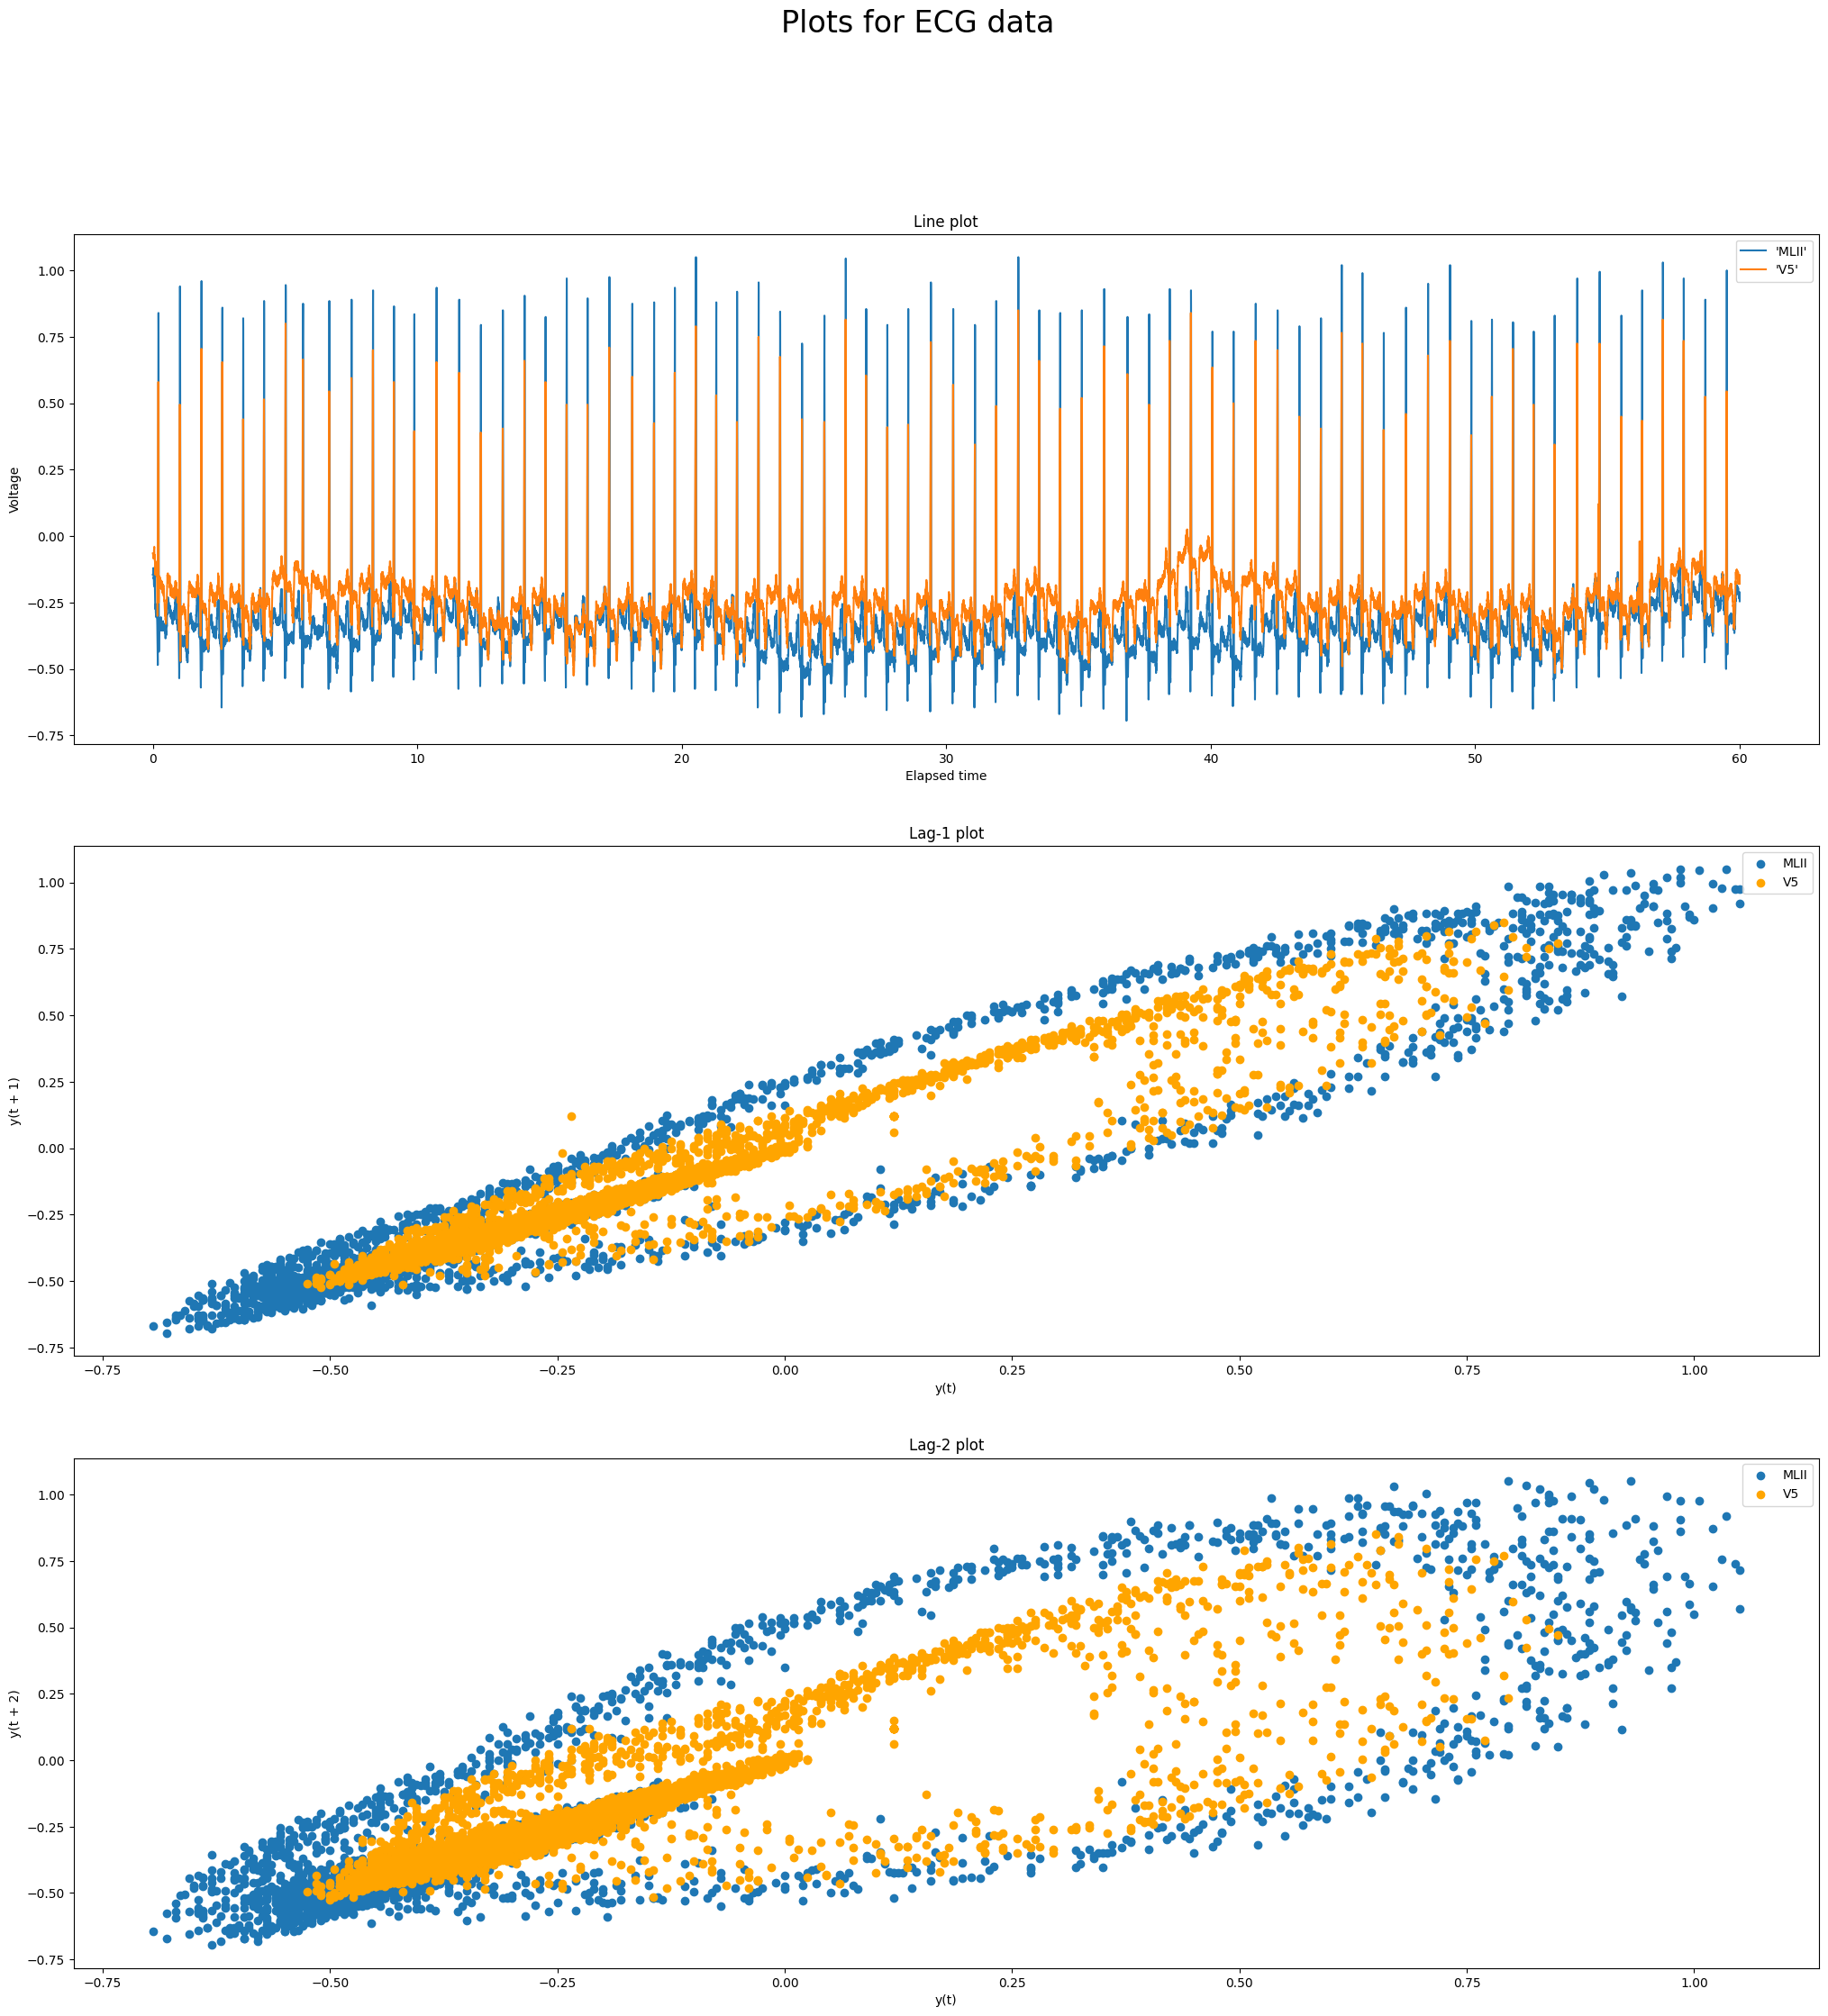

In [14]:
plot_all(data_pd)

### Model construction

In [15]:
# Split data into training and testing set
# Split training and testing sets into respective series
data_pd.reset_index(drop=True, inplace=True)
mlii = data_pd['\'MLII\'']
v5 = data_pd['\'V5\'']

train_mlii, test_mlii = split_data(mlii)
train_v5, test_v5 = split_data(v5)

INPUT = [4, 8, 16]

for input_size in INPUT:
    # Transform data into supervised learning data sets
    train_input_data_mlii, train_label_mlii = transform_data_set(train_mlii, input_size, 2)
    test_input_data_mlii, test_label_mlii = transform_data_set(test_mlii, input_size, 2)
    train_input_data_v5, train_label_v5 = transform_data_set(train_v5, input_size, 2)
    test_input_data_v5, test_label_v5 = transform_data_set(test_v5, input_size, 2)

    # TODO: Combine MLII and V5 data into one data set
    # train_bi = pd.Series(index = range(2 * len(data_pd)))
    # for i in np.arange(start = 0, stop = len(data_pd), step = 1):
    #     train_bi[i] = data_pd["\'MLII\'"][i]
    #     train_bi[i + 1] = data_pd["\'V5\'"][i]
    # # print(train_bi)

    DATASET = [[train_input_data_mlii, train_label_mlii, test_input_data_mlii, test_label_mlii], 
               [train_input_data_v5, train_label_v5, test_input_data_v5, test_label_v5]]

    j = 0
    for data in DATASET:
        if (j == 0):
            print("Current data set: MLII")
        else:
            print("Current data set: V5")
        
        # Construct and initiate LSTM model
        model = keras.models.Sequential()
        model.add(keras.layers.LSTM(5, input_shape=(input_size, 1), return_sequences=False))
        model.add(keras.layers.Dense(2))
        model.add(keras.layers.Activation('tanh'))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(data[0], data[1], epochs=5, batch_size=1, verbose=2)

        # Test model
        test_output = model.predict(data[2])

        # Find MSE, MAE, MAPE of test data
        test_mse = keras.losses.mean_squared_error(data[3], test_output)
        test_mae = keras.losses.mean_absolute_error(data[3], test_output)
        test_mape = keras.losses.mean_absolute_percentage_error(data[3], test_output)
        print('Current input size: %d' % input_size)
        print('Test MSE: %.4f' % (sum(test_mse) / 395))
        print('Test MAE: %.4f' % (sum(test_mae) / 395))
        print('Test MAPE: %.4f' % (sum(test_mape) / 395))
        j += 1

Current data set: MLII
Epoch 1/5
17275/17275 - 19s - loss: 0.0045 - 19s/epoch - 1ms/step
Epoch 2/5
17275/17275 - 18s - loss: 9.4810e-04 - 18s/epoch - 1ms/step
Epoch 3/5
17275/17275 - 17s - loss: 7.2322e-04 - 17s/epoch - 974us/step
Epoch 4/5
17275/17275 - 19s - loss: 6.2445e-04 - 19s/epoch - 1ms/step
Epoch 5/5
17275/17275 - 17s - loss: 5.9951e-04 - 17s/epoch - 983us/step
135/135 [==============================] - 0s 602us/step
Current input size: 4
Test MSE: 0.0085
Test MAE: 0.1755
Test MAPE: 67.0519
Current data set: V5
Epoch 1/5
17275/17275 - 16s - loss: 0.0029 - 16s/epoch - 909us/step
Epoch 2/5
17275/17275 - 15s - loss: 9.9958e-04 - 15s/epoch - 875us/step
Epoch 3/5
17275/17275 - 15s - loss: 8.2211e-04 - 15s/epoch - 874us/step
Epoch 4/5
17275/17275 - 15s - loss: 7.5279e-04 - 15s/epoch - 873us/step
Epoch 5/5
17275/17275 - 15s - loss: 7.1496e-04 - 15s/epoch - 876us/step
135/135 [==============================] - 0s 683us/step
Current input size: 4
Test MSE: 0.0093
Test MAE: 0.1846
Test 

### Anomaly detection

135/135 - 0s - 115ms/epoch - 854us/step
[-0.53755504 -0.5314131  -0.53697824 -0.53937936 -0.0328185   0.22834696
  0.5503978   0.74389786  0.7969325   0.7541608   0.61660486  0.3285572
 -0.099032   -0.07014898  0.2193927   0.5535983   0.7192678   0.7564213
  0.72426695  0.71533513  0.7520769   0.7233588   0.6202762   0.399548
  0.11194731 -0.08129594 -0.0419453   0.27201355  0.5621644   0.7170239
  0.7410334   0.6125356   0.38646278  0.00134828  0.021641    0.26909557
  0.54967916  0.7091659   0.722424    0.6307386   0.56831384  0.2972057
 -0.09000357 -0.00974005  0.30126435  0.5769988   0.7297298   0.73879725
  0.5784914   0.41771078  0.09507725  0.09914678  0.37758258  0.6018108
  0.66336626  0.657626    0.60522157  0.50450486  0.12101151 -0.03181577
  0.33647695  0.6201754   0.7336975   0.7376004   0.59933096  0.32867968
 -0.07283465  0.07147253  0.31747723  0.61048937  0.7722798   0.7806964
  0.7246551   0.66270036  0.41382864  0.06094669  0.05174959  0.25111005
  0.52114576  0.649

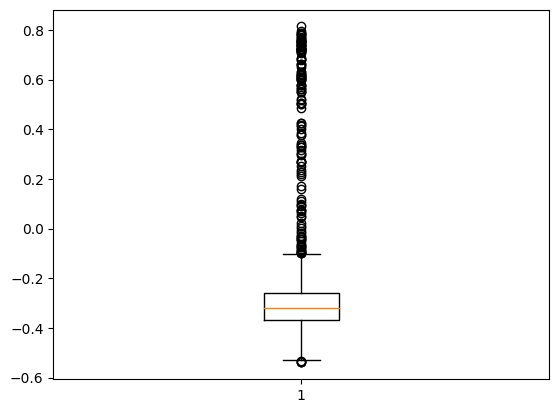

In [16]:
predictions = model.predict(test_input_data_mlii, verbose=2)
# detect_anomaly(predictions[:, 0], conf_interval = 0.99995)
boxplot_vals = boxplot(predictions[:, 0]);
print(boxplot_vals["fliers"][0].get_ydata())
